### Loading Dataset

In [ ]:
# Checking Available Devices
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17790736159095323110
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8033048471990841791
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9083268982805941779
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-malignant-vs-benign


### Data Preprocessing

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # will process data group by group (each group = 8 datapionts) in an epoch
DATA_DIR = path # Dataset path

# Loading and preprocess the dataset
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values in (0 - 1) range
    validation_split=0.2  # Reserve 20% for validation
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 5276 images belonging to 3 classes.
Found 1318 images belonging to 3 classes.


### Data Augmentation

In [ ]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_augmented_gen = augmented_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 5276 images belonging to 3 classes.
Found 1318 images belonging to 3 classes.


### Model Defination

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Model Training

In [ ]:
# Train the model
history = model.fit(
    train_augmented_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_augmented_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 109s 567ms/step - accuracy: 0.1146 - loss: 0.3850 - val_accuracy: 0.0998 - val_loss: 0.3444
Epoch 2/20
  1/164 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.1562 - loss: 0.7684

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1562 - loss: 0.7684 - val_accuracy: 0.1667 - val_loss: -1.1669
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 368ms/step - accuracy: 0.0939 - loss: 0.3615 - val_accuracy: 0.1006 - val_loss: 0.3385
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.0625 - loss: 0.5059 - val_accuracy: 0.0000e+00 - val_loss: 0.1536
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 373ms/step - accuracy: 0.1029 - loss: 0.3444 - val_accuracy: 0.1006 - val_loss: 0.3381
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.1250 - loss: 0.4461 - val_accuracy: 0.0000e+00 - val_loss: -0.5936
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.1044 - loss: 0.3369 - val_accuracy: 0.0998 - val_loss: 0.3475
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.0938 - loss: -0.2667 - val_accuracy: 0.1667 - val_loss: 0.5097
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 371ms/step - accuracy: 0.1008 - loss: 0.3050

### **Model Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
test_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Evaluate model
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()

# Print evaluation metrics
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant', 'Others']))

Found 1318 images belonging to 3 classes.
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       659
   Malignant       0.10      1.00      0.18       132
      Others       0.00      0.00      0.00       527

    accuracy                           0.10      1318
   macro avg       0.03      0.33      0.06      1318
weighted avg       0.01      0.10      0.02      1318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine Tuning

In [ ]:
# Fine-tuning (unfreezing some layers)
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


# Fine-tune the model
fine_tune_history = model.fit(
    train_augmented_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_augmented_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 151s 571ms/step - accuracy: 0.1007 - loss: 0.6926 - val_accuracy: 0.0991 - val_loss: 1.3030
Epoch 2/20
  1/164 ━━━━━━━━━━━━━━━━━━━━ 50s 313ms/step - accuracy: 0.0312 - loss: -0.9455

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0312 - loss: -0.9455 - val_accuracy: 0.3333 - val_loss: -9.1320
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - accuracy: 0.0980 - loss: 0.4136 - val_accuracy: 0.0998 - val_loss: 1.0827
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.0938 - loss: 2.6599 - val_accuracy: 0.1667 - val_loss: -1.4003
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.0994 - loss: 0.4179 - val_accuracy: 0.0998 - val_loss: 0.5515
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.1875 - loss: -0.1785 - val_accuracy: 0.1667 - val_loss: 2.2552
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - accuracy: 0.1115 - loss: 0.3893 - val_accuracy: 0.0991 - val_loss: 0.3874
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.0625 - loss: 0.7682 - val_accuracy: 0.3333 - val_loss: -2.7780
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 380ms/step - accuracy: 0.0997 - loss: 0.3955 - val_

### Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
test_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Evaluate model
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()

# Print evaluation metrics
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant', 'Others']))


Found 1318 images belonging to 3 classes.
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       659
   Malignant       0.10      1.00      0.18       132
      Others       0.00      0.00      0.00       527

    accuracy                           0.10      1318
   macro avg       0.03      0.33      0.06      1318
weighted avg       0.01      0.10      0.02      1318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


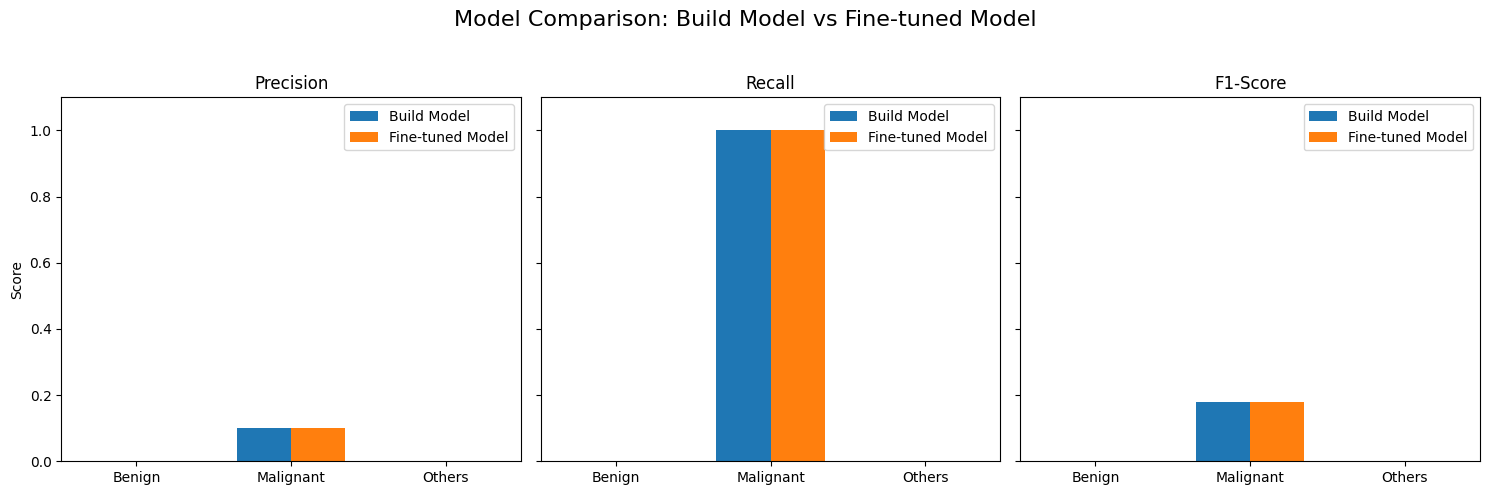

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the results as dictionaries
build_model_results = {
    "Benign": [0.00, 0.00, 0.00],
    "Malignant": [0.10, 1.00, 0.18],
    "Others": [0.00, 0.00, 0.00]
}

fine_tuned_model_results = {
    "Benign": [0.00, 0.00, 0.00],
    "Malignant": [0.10, 1.00, 0.18],
    "Others": [0.00, 0.00, 0.00]
}

metrics = ["Precision", "Recall", "F1-Score"]
classes = list(build_model_results.keys())

# Create dataframes for easy manipulation
build_df = pd.DataFrame(build_model_results, index=metrics)
fine_tuned_df = pd.DataFrame(fine_tuned_model_results, index=metrics)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Model Comparison: Build Model vs Fine-tuned Model", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    x = np.arange(len(classes))
    width = 0.35

    ax.bar(x - width/2, build_df.loc[metric], width, label="Build Model")
    ax.bar(x + width/2, fine_tuned_df.loc[metric], width, label="Fine-tuned Model")

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Score") if i == 0 else None
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
